In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [2]:
housing_data = pd.read_csv('AmesHousing.tsv', delimiter='\t')
housing_data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
housing_data.shape

(2930, 82)

# Functions for transforming, selecting and train/testing dataset

We'll create functions to transform, select and train/test the dataset.

In [4]:
#transforming features
def transform_features(df):
    null_list = df.isnull().sum() #list of columns with sum of missing values
    missing_val_cols_lessthan5 = null_list[null_list<(df.shape[0]*0.05)].index #column names with missing values of less than 5%
    df = df[missing_val_cols_lessthan5]
    return(df)
    
#selecting features
def select_features(df):
    df_with_features = df[['Overall Qual', 'SalePrice']]
    return(df_with_features)
    
#training and testing dataset
def train_and_test(df):
    train = df.loc[:(len(df)/2 - 1)]
    train_with_features = select_features(train)
    test = df.loc[(len(df)/2):]
    test_with_features = select_features(test)
    train_col = train_with_features.columns[train_with_features.columns!='SalePrice']
    
    lr = linear_model.LinearRegression()
    lr.fit(train_with_features[train_col], train_with_features['SalePrice'])
    predictions = lr.predict(test[train_col])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    return(rmse)

In [5]:
#testing functions
train_and_test(housing_data)

49555.27453834125

We just used `Overall Qual` as a test run of the functions. We got RMSE of 49555. Let's see if we can improve this error score.

# Tranforming Features

In [6]:
data = transform_features(housing_data.copy())
data.shape

(2930, 71)

Let's add a column for `years_until_remod` using `Year Remod/Add` and `Year Built`. We will also drop some columns that won't be helpful for the analysis due to irrelevance or data leakage.

In [7]:
#new column for years until remodeling
data['years_until_remod'] = data['Year Remod/Add'] - data['Year Built']

#columns to drop
drop_col = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Remod/Add', 'Year Built',
            'Sale Condition', 'Sale Type'] #columns to drop
data = data.drop(drop_col, axis=1)
data.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Area', 'Street', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Overall Qual', 'Overall Cond', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Garage Cars', 'Garage Area', 'Paved Drive', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
 

Replacing null values with the most commonly found values.

In [8]:
data = data.fillna(data.mode().iloc[0])
data.isnull().sum().value_counts()

0    64
dtype: int64

# Feature Selection

Let's explore the features and see if there are any outstanding correlations with `SalePrice`.

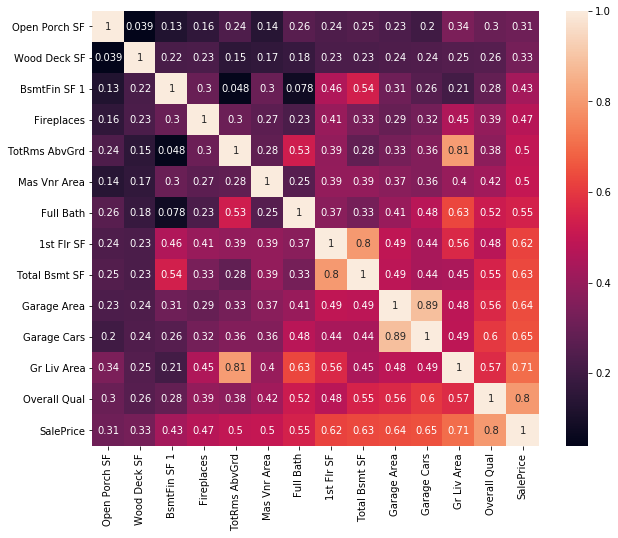

In [9]:
correlations = data.corr()
sorted_correlations = np.abs(correlations['SalePrice']).sort_values()
strong_correlations = sorted_correlations[sorted_correlations > 0.3]

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data[strong_correlations.index].corr(), 
            annot=True)

Some variables have high correlations with each other
* `Totrms AbvGrd` and `Gr Liv Area`
* `1st Flr SF` and `Total Bsmt SF`
* `Garage Area` and `Garage Cars`

To mitigate collinearity, we'll drop `Totrms AbvGrd`, `Total Bsmt SF`, and `Garage Cars`.

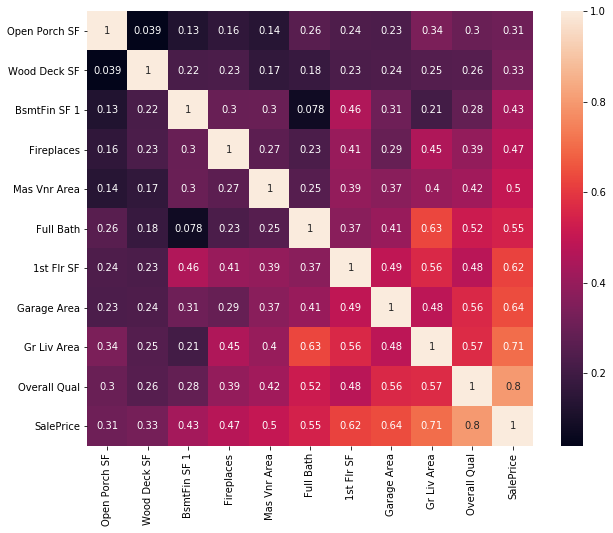

In [10]:
data = data.drop(['TotRms AbvGrd', 'Total Bsmt SF', 'Garage Cars'], axis=1)
correlations = data.corr()
sorted_correlations = np.abs(correlations['SalePrice']).sort_values()
strong_correlations = sorted_correlations[sorted_correlations > 0.3]

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data[strong_correlations.index].corr(), 
            annot=True)

With the dropped columns and using 0.6 as the coefficient cut-off line, we can see that `1st Flr SF`, `Garage Area`, `Gr Liv Area` and `Overall Qual` may be good features to use for our model. But we're not done yet! There are some columns that need to be converted into categorical variables, and some of these may be helpful in strengthening our model. There are two types of columns that need to be converted into categorical variables:
1. Columns with object values
2. Columns with numerical values that are nominal in nature

Columns with object values are easy to filter by coding. In this dataset, there aren't any numerical values that are nominal in nature.

In [11]:
categorical_columns = list(data.select_dtypes(include=['object']).columns)
print(categorical_columns)

['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Paved Drive']


# Categorical Variables

To use these features in our model, we need to transform them into numerical representations. We will convert them into a categorical data type.

The main issue here is that linear regression operates under the assumption that the features are linearly correlated with the target column. For the categorical feature, there's no actual numerical meaning to the categorical codes that pandas assigned for that column. To work around this issue, we will use dummy codes for some of these columns. Since columns have varying amounts of unique categorical values and/or they might not have low variance in their unique values, we will drop columns with:
1. The number of unique values greater than 10
2. More than 95% of the values belong in a specific category

After this, we will convert these columns into dummy columns and delete the original columns.

In [12]:
for column in categorical_columns:
    data[column] = data[column].astype('category')
    data_95_percent = data.shape[0] * 0.95 #95% of data
    if (len(data[column].unique()) > 10) or (any(data[column].value_counts() > data_95_percent)):
        data = data.drop(column, axis=1)
    else:
        dummies = pd.get_dummies(data[column], drop_first=True,prefix=str(column))
        data = pd.concat([data, dummies], axis=1)
        data = data.drop([column], axis=1)
data.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

Let's now focus on a limited group of features that have high correlation coefficients with `SalePrice`. Then, we'll ensure that all assumptions for linear regression are met.

In [13]:
correlations = data.corr()
sorted_correlations = np.abs(correlations['SalePrice']).sort_values()
strong_correlations = sorted_correlations[sorted_correlations > 0.5] #correlation coefficient higher than 0.5
data = data[strong_correlations.index]
data.head()

,Bsmt Qual_TA,Mas Vnr Area,Foundation_PConc,Kitchen Qual_TA,Full Bath,Exter Qual_TA,1st Flr SF,Garage Area,Gr Liv Area,Overall Qual,SalePrice
0,1,112.0,0,1,1,1,1656,528.0,1656,6,215000
1,1,0.0,0,1,1,1,896,730.0,896,5,105000
2,1,108.0,0,0,1,1,1329,312.0,1329,6,172000
3,1,0.0,0,0,2,0,2110,522.0,2110,7,244000
4,0,0.0,1,1,2,1,928,482.0,1629,5,189900


# Normalization

Let's take a look at all the continuous variables (both features and the target) to see if they're normally distributed.

((array([-3.49555212, -3.25141499, -3.11638513, ...,  3.11638513,
          3.25141499,  3.49555212]),
  array([ 12789,  13100,  34900, ..., 625000, 745000, 755000], dtype=int64)),
 (74825.86317555302, 180796.0600682594, 0.9358026011048889))

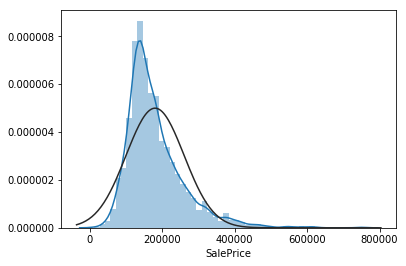

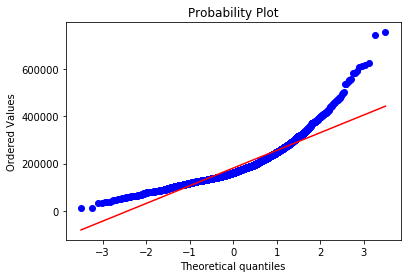

In [14]:
from scipy import stats

sns.distplot(data['SalePrice'], fit=stats.norm)
figure = plt.figure()
stats.probplot(data['SalePrice'], plot=plt)

`SalePrice` is positively skewed. Let's use log transformation to change this.

((array([-3.49555212, -3.25141499, -3.11638513, ...,  3.11638513,
          3.25141499,  3.49555212]),
  array([ 9.45634071,  9.48036751, 10.46024211, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.4049211767814778, 12.02096869011177, 0.9925610066837299))

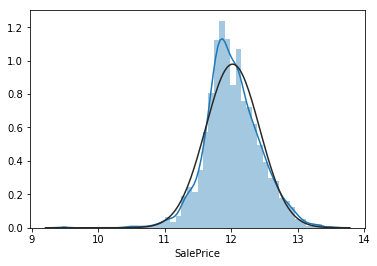

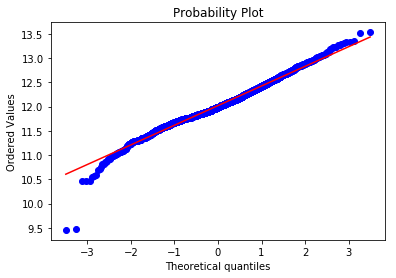

In [15]:
data['SalePrice'] = np.log(data['SalePrice'])

sns.distplot(data['SalePrice'], fit=stats.norm)
figure = plt.figure()
stats.probplot(data['SalePrice'], plot=plt)

Moving onto `Mas Vnr Area`.

((array([-3.49555212, -3.25141499, -3.11638513, ...,  3.11638513,
          3.25141499,  3.49555212]),
  array([   0.,    0.,    0., ..., 1290., 1378., 1600.])),
 (142.40487605386403, 101.09692832764505, 0.7964643930459994))

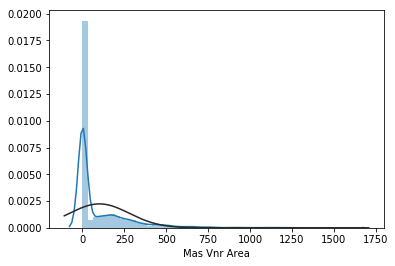

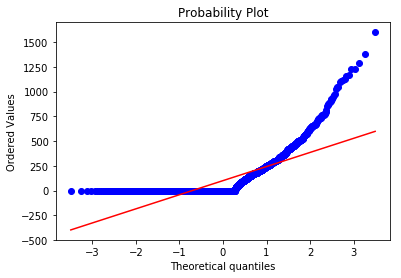

In [16]:
sns.distplot(data['Mas Vnr Area'], fit=stats.norm)
figure = plt.figure()
stats.probplot(data['Mas Vnr Area'], plot=plt)

That's a lot of 0s. We'll drop this feature. Moving onto `1st Flr SF`.

In [17]:
data = data.drop('Mas Vnr Area', axis=1)
data.head()

,Bsmt Qual_TA,Foundation_PConc,Kitchen Qual_TA,Full Bath,Exter Qual_TA,1st Flr SF,Garage Area,Gr Liv Area,Overall Qual,SalePrice
0,1,0,1,1,1,1656,528.0,1656,6,12.278393
1,1,0,1,1,1,896,730.0,896,5,11.561716
2,1,0,0,1,1,1329,312.0,1329,6,12.055250
3,1,0,0,2,0,2110,522.0,2110,7,12.404924
4,0,1,1,2,1,928,482.0,1629,5,12.154253


((array([-3.49555212, -3.25141499, -3.11638513, ...,  3.11638513,
          3.25141499,  3.49555212]),
  array([ 334,  372,  407, ..., 3820, 4692, 5095], dtype=int64)),
 (376.71016124867185, 1159.5576791808874, 0.9603933068220087))

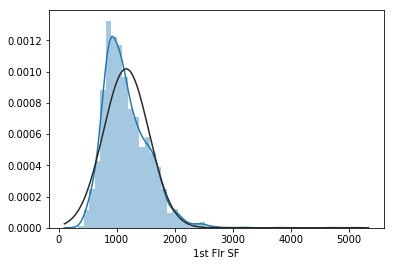

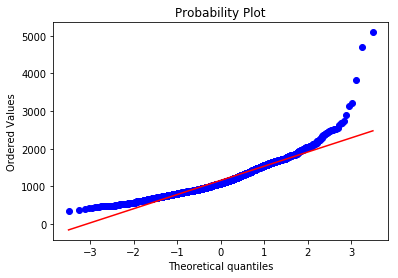

In [18]:
sns.distplot(data['1st Flr SF'], fit=stats.norm)
figure = plt.figure()
stats.probplot(data['1st Flr SF'], plot=plt)

Log function - again!

((array([-3.49555212, -3.25141499, -3.11638513, ...,  3.11638513,
          3.25141499,  3.49555212]),
  array([5.81114099, 5.91889385, 6.00881319, ..., 8.2480057 , 8.45361421,
         8.53601495])),
 (0.3223377036089913, 7.003309483968494, 0.9980183536332159))

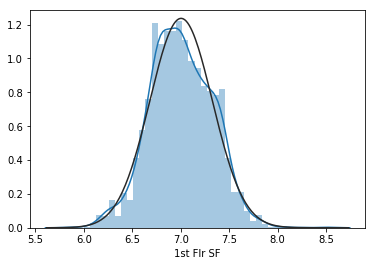

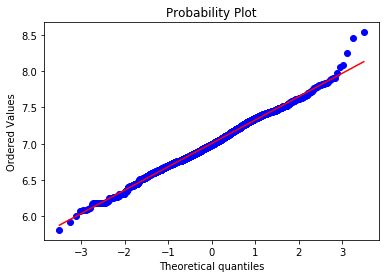

In [19]:
data['1st Flr SF'] = np.log(data['1st Flr SF'])

sns.distplot(data['1st Flr SF'], fit=stats.norm)
figure = plt.figure()
stats.probplot(data['1st Flr SF'], plot=plt)

((array([-3.49555212, -3.25141499, -3.11638513, ...,  3.11638513,
          3.25141499,  3.49555212]),
  array([   0.,    0.,    0., ..., 1390., 1418., 1488.])),
 (212.7258239769835, 472.65836177474404, 0.9876674496691953))

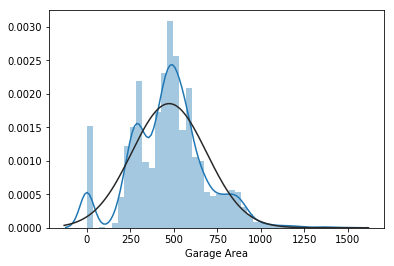

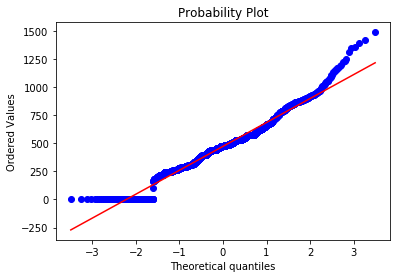

In [20]:
sns.distplot(data['Garage Area'], fit=stats.norm)
figure = plt.figure()
stats.probplot(data['Garage Area'], plot=plt)

This is a tricky one since a lot of datapoints are placed at 0. Following the suggestions from an excellent [Kaggle kernel](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python), we'll create a variable that can get the effect of having or not having a garage (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not having a garage.

In [21]:
data['HasGrg'] = pd.Series(len(data['Garage Area']), index=data.index)
data['HasGrg'] = 0 
data.loc[data['Garage Area']>0,'HasGrg'] = 1
data.loc[data['HasGrg']==1,'Garage Area'] = np.log(data['Garage Area'])

C:\Users\EunJin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


((array([-3.48073301, -3.2356255 , -3.10000544, ...,  3.10000544,
          3.2356255 ,  3.48073301]),
  array([4.60517019, 5.07517382, 5.07517382, ..., 7.23705903, 7.25700271,
         7.30518822])),
 (0.38096554574055685, 6.14276663639677, 0.9936718610411048))

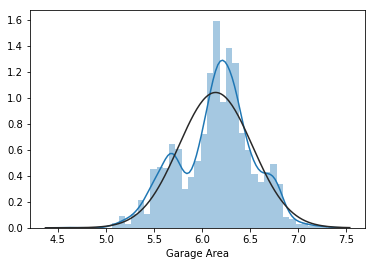

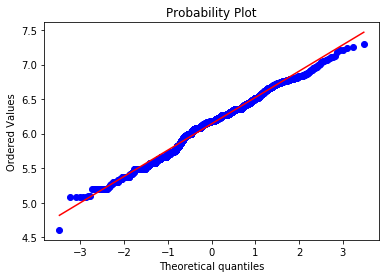

In [22]:
sns.distplot(data[data['Garage Area']>0]['Garage Area'], fit=stats.norm)
figure = plt.figure()
stats.probplot(data[data['Garage Area']>0]['Garage Area'], plot=plt)

Lastly, we'll look at `Gr Liv Area`.

((array([-3.49555212, -3.25141499, -3.11638513, ...,  3.11638513,
          3.25141499,  3.49555212]),
  array([ 334,  407,  438, ..., 4676, 5095, 5642], dtype=int64)),
 (488.6823093145101, 1499.6904436860068, 0.9658390813078276))

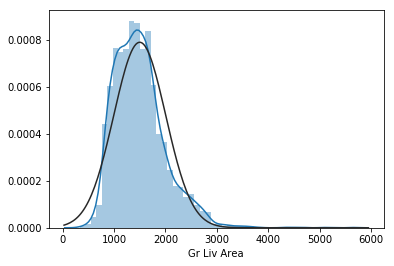

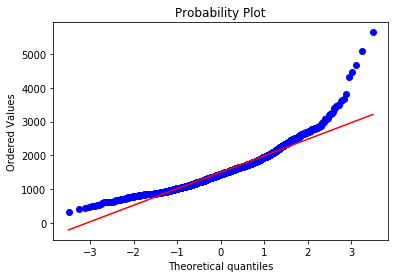

In [23]:
sns.distplot(data['Gr Liv Area'], fit=stats.norm)
figure = plt.figure()
stats.probplot(data['Gr Liv Area'], plot=plt)

You know the drill!

((array([-3.49555212, -3.25141499, -3.11638513, ...,  3.11638513,
          3.25141499,  3.49555212]),
  array([5.81114099, 6.00881319, 6.08221891, ..., 8.45019832, 8.53601495,
         8.63799389])),
 (0.324443727522434, 7.260127644825557, 0.9983452245775346))

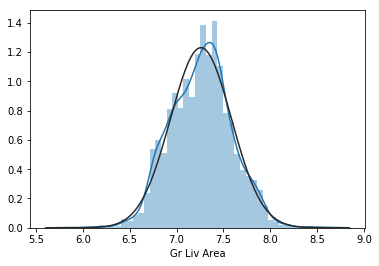

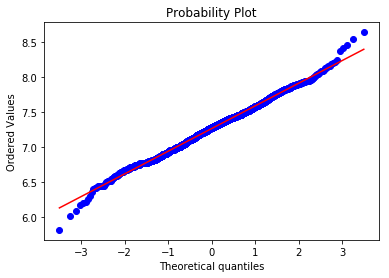

In [24]:
data['Gr Liv Area'] = np.log(data['Gr Liv Area'])

sns.distplot(data['Gr Liv Area'], fit=stats.norm)
figure = plt.figure()
stats.probplot(data['Gr Liv Area'], plot=plt)

# Homoscedasticity

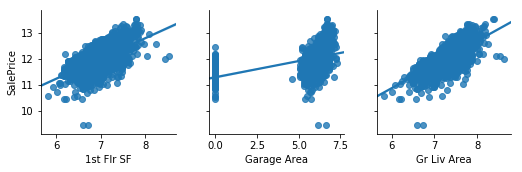

In [25]:
sns.pairplot(data,
             x_vars=['1st Flr SF', 'Garage Area', 'Gr Liv Area'],
             y_vars=['SalePrice'],
             kind='reg')

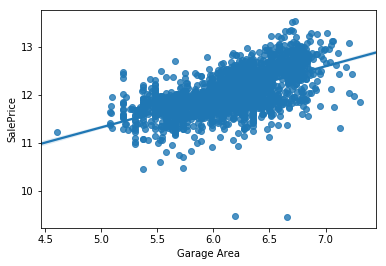

In [26]:
sns.regplot(data[data['Garage Area']>0]['Garage Area'], 
           data[data['Garage Area']>0]['SalePrice'],
           )

It seems like variance across continuous independent variables are equal - no cone-shaped relationships are observed. As with `Garage Area`, it shows a linear relationship with `SalePrice` with homoscedasticity when we take out the 0s. Not done yet! We see a couple outliers here at the bottom, so let's take them out.

# Outliers

In [27]:
data.sort_values(by=['SalePrice']).head()

,Bsmt Qual_TA,Foundation_PConc,Kitchen Qual_TA,Full Bath,Exter Qual_TA,1st Flr SF,Garage Area,Gr Liv Area,Overall Qual,SalePrice,HasGrg
181,0,0,1,1,1,6.723832,6.659294,6.723832,2,9.456341,1
1553,1,0,0,1,0,6.597146,6.188264,6.597146,1,9.480368,1
726,1,0,1,1,1,6.579251,0.000000,6.579251,4,10.460242,0
2843,1,0,1,1,1,6.210600,5.375278,6.210600,2,10.463103,1
2880,1,0,1,0,1,6.173786,5.730100,6.173786,2,10.471950,1


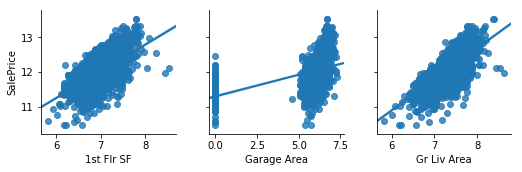

In [28]:
data = data.drop([181, 1553])
sns.pairplot(data,
             x_vars=['1st Flr SF', 'Garage Area', 'Gr Liv Area'],
             y_vars=['SalePrice'],
             kind='reg')

# Feature Standardization and Principal Component Analysis

To ensure that our features are normally distributed and mitigate multicollinearity and decrease the number of columns we have now, here are some of the steps we will take:
1. Scale values using StandardScaler
2. Run PCA to create a new dataframe

In [29]:
from sklearn.preprocessing import StandardScaler

#standardizing features (mean = 0 and variance = 1)
x = data.loc[:, data.columns!='SalePrice'].values
x = StandardScaler().fit_transform(x)
scaled_df = pd.DataFrame(x)
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9
0,1.072278,-0.899801,0.980384,-1.025511,0.792765,1.266589,0.318721,0.467453,-0.069711,0.23883
1,1.072278,-0.899801,0.980384,-1.025511,0.792765,-0.637308,0.544157,-1.426183,-0.780906,0.23883
2,1.072278,-0.899801,-1.020009,-1.025511,0.792765,0.584722,-0.047389,-0.210739,-0.069711,0.23883
3,1.072278,-0.899801,-1.020009,0.783342,-1.261408,2.017593,0.310767,1.214410,0.641484,0.23883
4,-0.932594,1.111357,0.980384,0.783342,0.792765,-0.528536,0.255288,0.416773,-0.780906,0.23883


In [30]:
from sklearn.decomposition import PCA
#principal component analysis
pca = PCA(whiten=True)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents)
new_data = pd.concat([principal_df, data['SalePrice']], axis = 1)

In [31]:
new_data.head()

,0,1,2,3,4,5,6,7,8,9,SalePrice
0,-0.498867,-0.908890,1.481744,-1.088988,-0.795550,-0.620052,-0.586732,-0.153572,0.491673,0.445175,12.278393
1,-1.124655,-0.907725,-0.482922,-0.288530,-0.090348,-0.073227,-0.058322,0.638592,-0.716713,2.585580,11.561716
2,-0.412032,-0.434020,0.413134,-1.954677,0.816955,0.447487,-0.093735,-1.623552,-0.537509,-1.052669,12.055250
3,0.784682,-0.282011,1.878872,-1.955032,1.418587,0.364797,0.685748,1.324229,0.093166,-0.521002,12.404924
4,0.059316,-0.116876,-0.180755,2.486714,-1.057203,0.910159,-0.854159,-0.411374,0.820261,0.100593,12.154253


# Updating functions

It's time for us to update our `tranform_features` and `select_feature` functions.

In [32]:
def transform_features(df):
    null_list = df.isnull().sum() #list of columns with sum of missing values
    missing_val_cols_lessthan5 = null_list[null_list<(df.shape[0]*0.05)].index #column names with missing values of less than 5%
    df = df.loc[:,missing_val_cols_lessthan5]
    df['years_until_remod'] = df['Year Remod/Add'] - df['Year Built']

    #columns to drop
    drop_col = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Remod/Add', 'Year Built',
                'Sale Condition', 'Sale Type', 'Mas Vnr Area']
    df = df.drop(drop_col, axis=1)
    
    #filling missing values
    df = df.fillna(df.mode().iloc[0])
    
    #categorical and dummy variables
    categorical_columns = list(df.select_dtypes(include=['object']).columns)
    for column in categorical_columns:
        df[column] = df[column].astype('category')
        df_95_percent = df.shape[0] * 0.95 #95% of data
        if (len(df[column].unique()) > 10) or (any(df[column].value_counts() > df_95_percent)):
            df = df.drop(column, axis=1)
        else:
            dummies = pd.get_dummies(df[column], drop_first=True, prefix=str(column))
            df = pd.concat([df, dummies], axis=1)
            df = df.drop([column], axis=1)
            
    #log function on continuous features
    df['SalePrice'] = np.log(df['SalePrice'])
    df['1st Flr SF'] = np.log(df['1st Flr SF'])
    df['Gr Liv Area'] = np.log(df['Gr Liv Area'])
    df['HasGrg'] = pd.Series(len(df['Garage Area']), index=df.index)
    df['HasGrg'] = 0 
    df.loc[df['Garage Area']>0,'HasGrg'] = 1
    df.loc[df['HasGrg']==1,'Garage Area'] = np.log(df['Garage Area'])
    df = df.drop(['HasGrg'], axis=1)
            
    return(df)
    
def select_features(df):
    #dropping collinear columns
    df = df.drop(['TotRms AbvGrd', 'Total Bsmt SF', 'Garage Cars'], axis=1)
    
    #filtering columns with high correlation coefficients
    correlations = df.corr()
    sorted_correlations = np.abs(correlations['SalePrice']).sort_values()
    strong_correlations = sorted_correlations[sorted_correlations > 0.4]
    df = df[strong_correlations.index]
    
    #standardizing features (mean = 0 and variance = 1)
    x = df.loc[:, df.columns!='SalePrice'].values
    x = StandardScaler().fit_transform(x)

    #principal component analysis
    pca = PCA(whiten=True)
    principal_components = pca.fit_transform(x)
    principal_df = pd.DataFrame(data = principal_components)
    df = pd.concat([principal_df, df['SalePrice']], axis = 1)    
    return(df)

Lastly, to bootstrap our model, we will add cross-validation to the `train_and_test` function.

In [33]:
from sklearn.model_selection import cross_val_score, KFold

def train_and_test(df):
    #folding with k value of 10
    kf = KFold(10, shuffle=True, random_state=3)
    
    #applying functions to transform and select features
    df = transform_features(df.copy())
    df = select_features(df.copy())
    
    #train and test
    train_col = df.columns[df.columns!='SalePrice']
    lr = linear_model.LinearRegression()
    mses = cross_val_score(lr, df[train_col], df['SalePrice'], 
                           scoring='neg_mean_squared_error', cv=kf)
    rmse = np.sqrt(np.abs(mses))
    return(np.mean(rmse))

train_and_test(housing_data)

C:\Users\EunJin\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


0.16482378508392365

We got 0.1648 as the RMSE score. Looking at the leading Kaggle kernels for the same dataset, the score is not nearly as close as the leading scores. But that wasn't the scope of the project! We wanted to use a multivariate regression model to predict housing prices and ensuring that all data assumptions are met. 